In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from PIL import Image

import json

from collections import OrderedDict

In [3]:
data_dir = '/content/drive/MyDrive/gpc_classification/gpc_classification'
train_dir = data_dir + '/train4'
valid_dir = data_dir + '/2'
test_dir = data_dir + '/3'




data_transforms = {
        'train' : transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ]),
        'valid' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                     ]),
        'test' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                    ])
}


image_datasets = {
        'train' : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
        'valid' : datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
        'test' : datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}


dataloaders = {
        'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
        'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32),
        'test' : torch.utils.data.DataLoader(image_datasets['test'], batch_size=32)
}

In [4]:
model = models.vgg19(pretrained=False)


classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.3)),
                          ('fc2', nn.Linear(4096, 6)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier


criterion = nn.NLLLoss()
learn_rate = 0.001
optimizer = optim.Adam(model.classifier.parameters(), lr=learn_rate)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
def validation(model, validloader, criterion):
    test_loss = 0
    accuracy = 0
    for inputs, labels in validloader:

        inputs, labels = inputs.to(device), labels.to(device)

        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

In [6]:
import torch

# 変数の定義
epochs = 200
print_every = 2
steps = 0
train_losses = []  # 各エポックの訓練損失を記録するリスト
patience = 100  # アーリーストッピングの許容範囲（10エポック改善なしで停止）
best_valid_loss = float('inf')  # 最小検証損失の初期化
early_stop_counter = 0  # 改善がないエポック数のカウント

model.to(device)

for e in range(epochs):
    running_loss = 0
    # 各エポックの総バッチ数を取得
    total_steps = len(dataloaders['train'])

    for ii, (inputs, labels) in enumerate(dataloaders['train']):
        steps += 1

        # 入力データとラベルをデバイスに転送
        inputs, labels = inputs.to(device), labels.to(device)

        # 勾配の初期化
        optimizer.zero_grad()

        # 順伝播
        outputs = model.forward(inputs)
        # 損失の計算
        loss = criterion(outputs, labels)
        # 逆伝播
        loss.backward()
        # 最適化ステップ
        optimizer.step()

        running_loss += loss.item()

        # 各エポックの進捗率を表示
        progress = (ii + 1) / total_steps * 100
        print(f"Epoch [{e+1}/{epochs}], Step [{ii+1}/{total_steps}], Progress: {progress:.2f}%")

        if steps % print_every == 0:
            # 検証モードに切り替え
            model.eval()
            with torch.no_grad():
                # 検証データの損失と精度を計算
                test_loss, accuracy = validation(model, dataloaders['valid'], criterion)

            # 各エポックごとに結果を出力
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Valid Loss: {:.3f}.. ".format(test_loss/len(dataloaders['valid'])),
                  "Valid Accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

            # 最小検証損失の更新
            if test_loss < best_valid_loss:
                best_valid_loss = test_loss
                early_stop_counter = 0  # 改善が見られたのでカウンターをリセット
            else:
                early_stop_counter += 1  # 改善がないのでカウンターを増加

            # patience回数分改善が見られなければトレーニングを停止
            if early_stop_counter >= patience:
                print(f"Early stopping triggered. Training stopped at epoch {e+1}")
                break  # 外部のループも終了

            # 損失のリセットとトレーニングモードに戻す
            running_loss = 0
            model.train()

    # エポックごとの平均訓練損失を `train_losses` に追加
    train_losses.append(running_loss / total_steps)

    # アーリーストッピングで停止した場合、外部のエポックループも終了
    if early_stop_counter >= patience:
        break

# 結果の確認
print("Training losses over epochs:", train_losses)


Epoch [1/200], Step [1/2], Progress: 50.00%
Epoch [1/200], Step [2/2], Progress: 100.00%
Epoch: 1/200..  Training Loss: 3.737..  Valid Loss: 11.631..  Valid Accuracy: 0.266
Epoch [2/200], Step [1/2], Progress: 50.00%
Epoch [2/200], Step [2/2], Progress: 100.00%
Epoch: 2/200..  Training Loss: 8.197..  Valid Loss: 2.480..  Valid Accuracy: 0.609
Epoch [3/200], Step [1/2], Progress: 50.00%
Epoch [3/200], Step [2/2], Progress: 100.00%
Epoch: 3/200..  Training Loss: 3.607..  Valid Loss: 2.821..  Valid Accuracy: 0.062
Epoch [4/200], Step [1/2], Progress: 50.00%
Epoch [4/200], Step [2/2], Progress: 100.00%
Epoch: 4/200..  Training Loss: 3.465..  Valid Loss: 0.949..  Valid Accuracy: 0.609
Epoch [5/200], Step [1/2], Progress: 50.00%
Epoch [5/200], Step [2/2], Progress: 100.00%
Epoch: 5/200..  Training Loss: 1.442..  Valid Loss: 1.551..  Valid Accuracy: 0.266
Epoch [6/200], Step [1/2], Progress: 50.00%
Epoch [6/200], Step [2/2], Progress: 100.00%
Epoch: 6/200..  Training Loss: 1.794..  Valid Loss

In [7]:
model.eval()
with torch.no_grad():
    test_loss, accuracy = validation(model, dataloaders['test'], criterion)

print("Test Loss: {:.3f}.. ".format(test_loss/len(dataloaders['test'])),
      "Test Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

Test Loss: 0.228..  Test Accuracy: 0.908


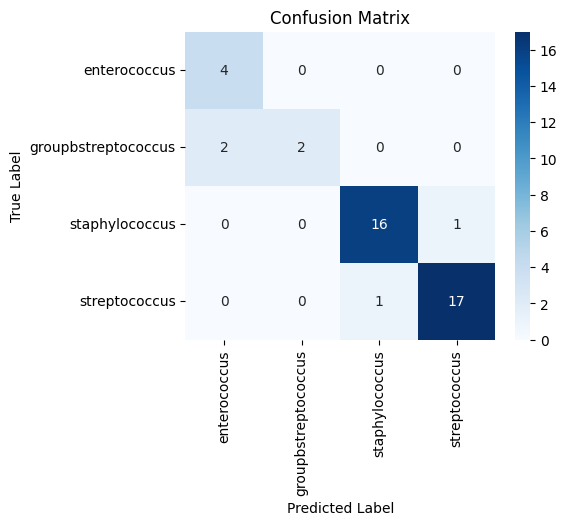

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# テストデータに対して予測を行う関数を追加
def predict(model, dataloader):
    all_labels = []
    all_preds = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model.forward(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

# 混同行列を計算
test_labels, test_preds = predict(model, dataloaders['test'])
conf_matrix = confusion_matrix(test_labels, test_preds)

# 混同行列の可視化
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=image_datasets['test'].classes,
            yticklabels=image_datasets['test'].classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
